# pbh

> A module to model and calculate the properties of primordial black holes (PBHs), such as density, mass, distance, and velocity distribution.

In [1]:
#| default_exp pbh

In [6]:
#| hide
from nbdev.showdoc import *

In [1]:
#| export
from LensCalcPy.parameters import *
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2


In [41]:
#| export
class Pbh:
    """A class to represent a PBH population"""

    def __init__(self,
                m_pbh: float, # PBH mass in solar masses
                f_dm: float # PBH fraction of the DM density
                ):
        """
        Initialize the PBH population
        """
        self.m_pbh = m_pbh
        if f_dm < 0 or f_dm > 1:
            raise ValueError("f_dm must be between 0 and 1")
        self.f_dm = f_dm
    
    def __str__(self) -> str:
        return f"PBH population with m_pbh={self.m_pbh} and f_dm={self.f_dm}"
    __repr__ = __str__

    def density(self, 
                r: float # distance in kpc
                ) -> float:
        """PBH density at a given distance from the Milky Way center
        Using an NFW profile

        Args:
            r (float): distance in kpc

        Returns:
            float: PBH density in Msol/kpc^-3
        """
        return rhoc / ((r/rs) * (1 + r/rs)**2) * self.f_dm
    
    def mass_enclosed(self, 
                      r: float, # distance from MW center in kpc
                      ) -> float:
        """PBH mass enclosed within a given distance from the Milky Way center

        Returns:
            float: PBH mass in Msol
        """
        return 4*np.pi * rhoc * rs**3 * (np.log(1 + r/rs) - (r/rs)/(1 + r/rs))
    
    def velocity_dispersion(self, 
                            d: float # distance from Sun in kpc
                            ) -> float:
        """PBH velocity dispersion at a given distance from the Milky Way center
        Returns:
            float: PBH velocity dispersion in km/s
        """
        r = self.dist_mw(d)
        return np.sqrt(G * self.mass_enclosed(r) / r) 
    
    def velocity_radial(self,
                        d: float, # distance from the Sun
                        umin: float, # minimum impact parameter
                        t: float # crossing time
                        ) -> float:
        """
        PBH radial velocity at a given distance from the Sun
        """
        return 2*self.einstein_rad(d) * (ut**2 - umin**2)**(1/2) / t * kpctokm

    
    def dist(self,
             d: float # distance from the Sun
             ) -> float:
        return d * (1 - d/ds)

    def einstein_rad(self, 
                     d: float, # distance from the Sun
                     ) -> float:
        return np.real((4 * G * self.m_pbh * self.dist(d)/c**2)**(1/2))
    
    def dist_mw(self, d):
        """returns the distance to the Milky Way center in kpc of a point a distance d to the Sun in kpc"""
        return np.sqrt(d**2 + rEarth**2 - 2*d*rEarth*np.cos(np.radians(l))*np.cos(np.radians(b)))
    


In [42]:
from scipy.integrate import nquad, dblquad

In [43]:
def integrand(umin, d, pbh, t):
    r = pbh.dist_mw(d)
    return (1 / (ut**2 - umin**2)**0.5 *
            pbh.density(r) / (pbh.m_pbh * pbh.velocity_dispersion(d)**2) *
            pbh.velocity_radial(d, umin, t * htosec)**4 * (htosec / kpctokm)**2 *
            np.exp(-(pbh.velocity_radial(d, umin, t * htosec)**2 / pbh.velocity_dispersion(d)**2)))



In [44]:
pbh = Pbh(1e-8, 1)

In [45]:
pbh.einstein_rad(1) 

1.312114389137824e-12

In [46]:
pbh.mass_enclosed(pbh.dist_mw(0))

30357871152.76634

In [47]:
pbh.velocity_dispersion(0)

123.92542632182672

In [48]:
pbh.velocity_radial(1, 0.1, 0.1*htosec)

217.58955553982693

In [49]:
umin_bounds = [0, ut]
d_bounds = [0, rEarth]

#Matches mathematica for high t but not low t
t = 0.1

result, error = nquad(integrand, [umin_bounds, d_bounds], args=(pbh, t))
# result, error = dblquad(integrand, d_bounds[0], d_bounds[1], lambda umin: umin_bounds[0], lambda umin: umin_bounds[1], args=(pbh, t))


print(result)

4.5932360387205447e-07


In [50]:
ts = np.logspace(-2, 1, 100)
result = np.zeros(len(ts))
for i, t in enumerate(ts):
    result[i], _ = nquad(integrand, [umin_bounds, d_bounds], args=(pbh, t))

/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


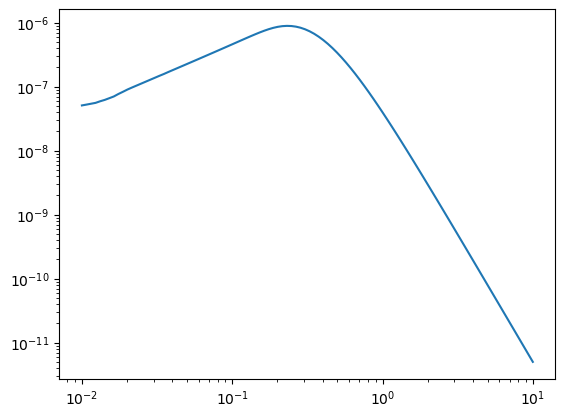

In [51]:
plt.loglog(ts, result)


In [19]:
?integrand

Signature: integrand(umin, d, pbh, t)
Docstring: <no docstring>
File:      /var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_79044/1292109548.py
Type:      function


In [28]:
dd = np.logspace(-2, np.log10(rEarth), 100)
result_integrand = np.zeros(len(dd))
for i, d in enumerate(dd):
    # result_vr[i] = pbh.velocity_radial(1, 0.1, t * htosec)
    result_integrand[i] = integrand(0.1, d, pbh, 0.1)

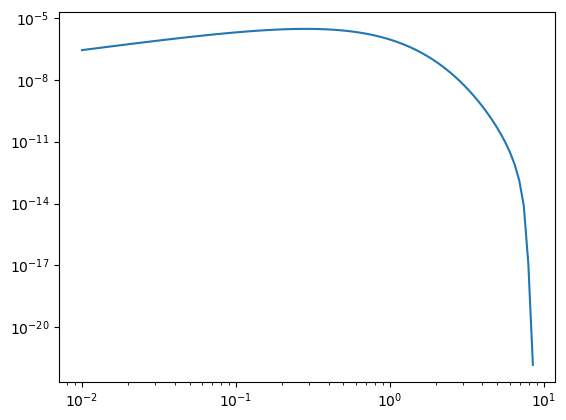

In [29]:
plt.loglog(dd, result_integrand)

In [38]:
#integrand doesn't agree
integrand(0.1, 8, pbh, 0.1)

3.2866430386501477e-18

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()